In [1]:
# imports for notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [2]:
# read in the dates and their recorded unique characteristics
dates = pd.read_csv('C:/Users/TWood/Downloads/m5-forecasting-accuracy/calendar.csv', parse_dates=[0])

In [ ]:
# take a look at the dates df
dates

In [3]:
# most days have no event, replace NaN with "None"
dates.replace(np.NaN, 'None', inplace=True)

In [4]:
dates.drop(columns=['weekday', 'year', 'wm_yr_wk', 'event_type_1', 'event_type_2', 'snap_TX', 'snap_WI'], inplace=True)

In [5]:
# read in the training data
val = pd.read_csv('C:/Users/TWood/Downloads/m5-forecasting-accuracy/sales_train_validation.csv')

In [16]:
val

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [6]:
CA1_F = val[(val['store_id'] == 'CA_1')&(val['cat_id'] == 'FOODS')]

In [8]:
CA1_F.drop(columns=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], inplace=True)

C:\Users\TWood\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [9]:
items = CA1_F['id'].unique()

In [10]:
CA1_F_ts = CA1_F.melt(id_vars=['id'], var_name='d', value_name='sales')

In [11]:
period = (CA1_F_ts['id']==items[0]).sum()

In [12]:
CA1_F_ts = CA1_F_ts.merge(dates, how='inner', on='d')

In [13]:
CA1_F_ts['lag_1'] = CA1_F_ts['sales'].shift(periods=period*1)

In [14]:
CA1_F_ts['lag_2'] = CA1_F_ts['sales'].shift(periods=period*2)

In [15]:
CA1_F_ts['lag_3'] = CA1_F_ts['sales'].shift(periods=period*3)

In [16]:
CA1_F_ts['lag_4'] = CA1_F_ts['sales'].shift(periods=period*4)

In [17]:
CA1_F_ts['lag_5'] = CA1_F_ts['sales'].shift(periods=period*5)

In [18]:
CA1_F_ts['lag_6'] = CA1_F_ts['sales'].shift(periods=period*6)

In [19]:
CA1_F_ts['lag_7'] = CA1_F_ts['sales'].shift(periods=period*7)

In [20]:
CA1_F_ts['lag_14'] = CA1_F_ts['sales'].shift(periods=period*14)

In [21]:
CA1_F_ts['lag_21'] = CA1_F_ts['sales'].shift(periods=period*21)

In [22]:
CA1_F_ts['lag_28'] = CA1_F_ts['sales'].shift(periods=period*28)

In [23]:
CA1_F_ts

,id,d,sales,date,wday,month,event_name_1,event_name_2,snap_CA,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_14,lag_21,lag_28
0,FOODS_1_001_CA_1_validation,d_1,3,2011-01-29,1,1,None,None,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FOODS_1_002_CA_1_validation,d_1,0,2011-01-29,1,1,None,None,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FOODS_1_003_CA_1_validation,d_1,0,2011-01-29,1,1,None,None,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FOODS_1_004_CA_1_validation,d_1,0,2011-01-29,1,1,None,None,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FOODS_1_005_CA_1_validation,d_1,3,2011-01-29,1,1,None,None,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2748976,FOODS_3_823_CA_1_validation,d_1913,1,2016-04-24,2,4,None,None,0,3.0,0.0,2.0,0.0,3.0,1.0,7.0,0.0,0.0,1.0
2748977,FOODS_3_824_CA_1_validation,d_1913,0,2016-04-24,2,4,None,None,0,0.0,0.0,2.0,6.0,14.0,0.0,8.0,0.0,3.0,1.0
2748978,FOODS_3_825_CA_1_validation,d_1913,2,2016-04-24,2,4,None,None,0,2.0,1.0,0.0,4.0,1.0,0.0,0.0,3.0,1.0,0.0
2748979,FOODS_3_826_CA_1_validation,d_1913,0,2016-04-24,2,4,None,None,0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0


In [24]:
CA1_F_ts.set_index('date', inplace=True)

In [25]:
items[0]

'FOODS_1_001_CA_1_validation'

In [26]:
for col in ['event_name_1', 'event_name_2']:
    label = LabelEncoder().fit(CA1_F_ts[col])
    CA1_F_ts[col] = label.transform(CA1_F_ts[col])

In [27]:
CA1_F_ts

,id,d,sales,wday,month,event_name_1,event_name_2,snap_CA,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_14,lag_21,lag_28
date,,,,,,,,,,,,,,,,,,
2011-01-29,FOODS_1_001_CA_1_validation,d_1,3,1,1,19,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-29,FOODS_1_002_CA_1_validation,d_1,0,1,1,19,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-29,FOODS_1_003_CA_1_validation,d_1,0,1,1,19,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-29,FOODS_1_004_CA_1_validation,d_1,0,1,1,19,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-29,FOODS_1_005_CA_1_validation,d_1,3,1,1,19,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-24,FOODS_3_823_CA_1_validation,d_1913,1,2,4,19,3,0,3.0,0.0,2.0,0.0,3.0,1.0,7.0,0.0,0.0,1.0
2016-04-24,FOODS_3_824_CA_1_validation,d_1913,0,2,4,19,3,0,0.0,0.0,2.0,6.0,14.0,0.0,8.0,0.0,3.0,1.0
2016-04-24,FOODS_3_825_CA_1_validation,d_1913,2,2,4,19,3,0,2.0,1.0,0.0,4.0,1.0,0.0,0.0,3.0,1.0,0.0


In [28]:
preds = []
trues = []
for item in items:
    ts = CA1_F_ts[CA1_F_ts['id'] == item].drop(columns=['d', 'id'])
    train = ts['2014-03-28':'2016-03-28']
    test = ts['2016-03-28':]
    X_train = train.drop('sales', axis=1)
    X_test = test.drop('sales', axis=1)
    y_train = train['sales']
    y_test = test['sales']
    lgbm = LGBMRegressor().fit(X_train, y_train)
    preds.append(lgbm.predict(X_test))
    trues.append(y_test)

In [29]:
preds

[array([1.57974644, 1.78367524, 0.96756988, 0.51927894, 1.07155703,
        2.01418193, 0.86652714, 0.18799438, 1.11275093, 1.13037194,
        1.41268475, 1.26084251, 1.06847586, 1.39385703, 0.064671  ,
        0.73590017, 0.10019928, 1.83687163, 1.92986966, 1.40528916,
        0.82655803, 0.56375061, 0.22169669, 0.62670377, 0.83304105,
        1.47156668, 1.9531481 , 0.68646032]),
 array([ 0.26733117,  0.26357408,  0.4373675 ,  0.7448561 ,  0.392034  ,
         1.16088463,  0.93501712,  0.68755766,  0.12784565,  0.12006629,
         0.13615067, -0.23745362,  0.44120014,  1.1071274 , -0.05935591,
         0.40190733,  0.7742565 ,  0.54611308,  0.27549005,  0.58639004,
         0.54869334,  0.59604876,  0.38408426,  0.14292489,  0.97579328,
         0.41477191,  0.86940306,  0.56878214]),
 array([ 2.66175529,  0.08676354,  1.1490976 ,  0.63802993,  0.93056542,
         1.04600441,  0.596954  ,  1.52228041,  0.88919391,  1.23783985,
         1.00385014,  1.25368634, -0.04068084,  0.8877

In [30]:
trues

[date
 2016-03-28    2
 2016-03-29    1
 2016-03-30    1
 2016-03-31    0
 2016-04-01    4
 2016-04-02    0
 2016-04-03    0
 2016-04-04    4
 2016-04-05    1
 2016-04-06    3
 2016-04-07    0
 2016-04-08    1
 2016-04-09    0
 2016-04-10    2
 2016-04-11    2
 2016-04-12    0
 2016-04-13    1
 2016-04-14    1
 2016-04-15    0
 2016-04-16    2
 2016-04-17    0
 2016-04-18    4
 2016-04-19    1
 2016-04-20    1
 2016-04-21    0
 2016-04-22    1
 2016-04-23    1
 2016-04-24    0
 Name: sales, dtype: int64,
 date
 2016-03-28    0
 2016-03-29    1
 2016-03-30    0
 2016-03-31    0
 2016-04-01    0
 2016-04-02    0
 2016-04-03    0
 2016-04-04    0
 2016-04-05    0
 2016-04-06    1
 2016-04-07    0
 2016-04-08    0
 2016-04-09    0
 2016-04-10    0
 2016-04-11    1
 2016-04-12    0
 2016-04-13    0
 2016-04-14    1
 2016-04-15    1
 2016-04-16    3
 2016-04-17    1
 2016-04-18    0
 2016-04-19    0
 2016-04-20    1
 2016-04-21    2
 2016-04-22    0
 2016-04-23    0
 2016-04-24    0
 Name: s

In [33]:
for pred in preds:
    pred[pred < 0] = 0

In [34]:
index = trues[0].index

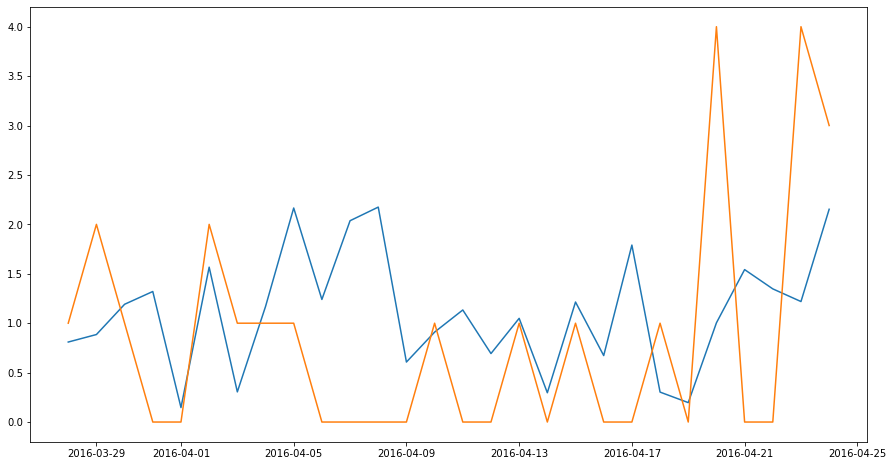

In [36]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(pd.Series(preds[29]).set_axis(index))
ax.plot(trues[29])

In [37]:
true_units = []
for true in trues:
    true_units.append(true.sum())

In [38]:
pred_units = []
for pred in preds:
    pred_units.append(pred.sum())

In [39]:
true_units[0]

33

In [40]:
pred_units[0]

29.625240138361903

In [41]:
mean_squared_error(true_units, pred_units, squared=True)

2701.0349863317415

In [72]:
true_units

[27,
 2,
 16,
 51,
 38,
 17,
 11,
 228,
 25,
 19,
 1,
 5,
 14,
 42,
 79,
 169,
 39,
 0,
 286,
 6,
 12,
 13,
 39,
 3,
 18,
 7,
 10,
 19,
 46,
 172,
 7,
 81,
 5,
 16,
 7,
 28,
 19,
 16,
 5,
 28,
 6,
 16,
 46,
 14,
 7,
 27,
 32,
 440,
 13,
 60,
 5,
 6,
 6,
 2,
 63,
 39,
 18,
 10,
 11,
 2,
 5,
 4,
 54,
 2,
 17,
 96,
 18,
 7,
 3,
 25,
 14,
 25,
 10,
 21,
 17,
 46,
 16,
 22,
 23,
 3,
 23,
 39,
 44,
 32,
 4,
 12,
 56,
 146,
 56,
 1,
 7,
 1,
 0,
 7,
 20,
 23,
 21,
 3,
 86,
 9,
 9,
 16,
 8,
 24,
 22,
 4,
 11,
 3,
 5,
 2,
 12,
 25,
 3,
 9,
 21,
 25,
 9,
 40,
 26,
 33,
 15,
 40,
 18,
 8,
 24,
 33,
 16,
 50,
 2,
 121,
 7,
 2,
 36,
 1,
 25,
 17,
 58,
 27,
 5,
 26,
 33,
 18,
 219,
 38,
 0,
 24,
 26,
 17,
 44,
 46,
 87,
 38,
 29,
 109,
 53,
 14,
 39,
 2,
 8,
 36,
 8,
 71,
 26,
 13,
 165,
 8,
 10,
 27,
 21,
 0,
 1,
 11,
 28,
 156,
 38,
 14,
 6,
 3,
 4,
 20,
 37,
 26,
 9,
 360,
 3,
 7,
 2,
 43,
 41,
 24,
 2,
 17,
 9,
 15,
 25,
 21,
 13,
 16,
 5,
 48,
 6,
 53,
 100,
 0,
 40,
 2,
 27,
 6,
 38,
 2,
 7,
 4

In [73]:
pred_units

[15.636487530320007,
 7.425506482788818,
 13.176160100855405,
 62.94389869458019,
 28.553622689238203,
 27.885573864373065,
 9.54235530777578,
 198.16407464924293,
 26.95357310878017,
 28.05076667229647,
 4.701888618980903,
 9.201102176718118,
 11.553305791155681,
 48.87401628999978,
 158.80271956172814,
 123.1272645131144,
 39.73277276722901,
 3.900787496138718,
 204.0727418584705,
 5.606718115646633,
 21.01916957503395,
 9.632838855172295,
 17.467680672041464,
 7.876443809763717,
 20.780143284059495,
 0.9209515636945642,
 12.195158735655204,
 13.518573743766355,
 46.537085494409425,
 151.50283233698457,
 7.801661751788298,
 99.07309395174502,
 9.615909728631229,
 17.15115756068504,
 2.9443339248186553,
 19.523222023443886,
 18.754022112723693,
 17.379222499767778,
 3.19400001192474,
 13.11848534453962,
 8.51236915520316,
 13.144779218738398,
 82.1411496378061,
 24.96870828138817,
 6.088388126022688,
 10.363918270523639,
 26.455719462318914,
 311.23794492562246,
 12.9568175543445,
 22

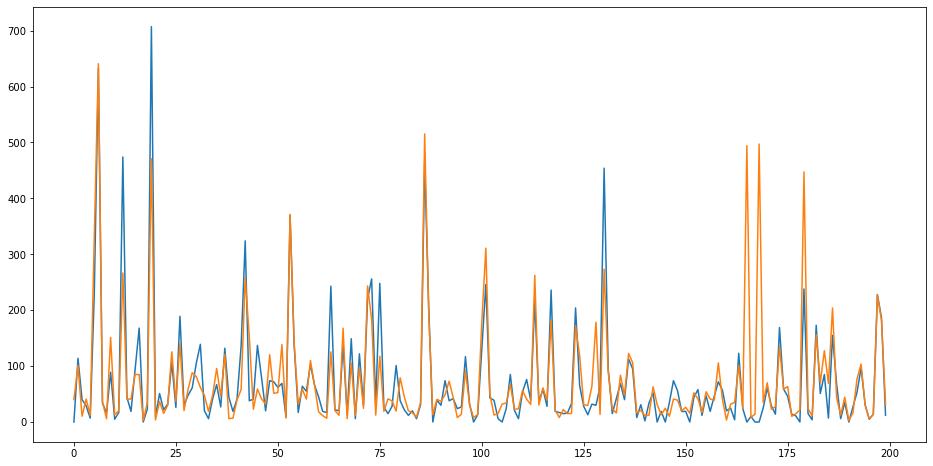

In [93]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(true_units[2500:2700])
ax.plot(pred_units[2500:2700])

In [85]:
resids = np.array(true_units) - np.array(pred_units)

In [89]:
resids.mean()

-0.13532765773668876

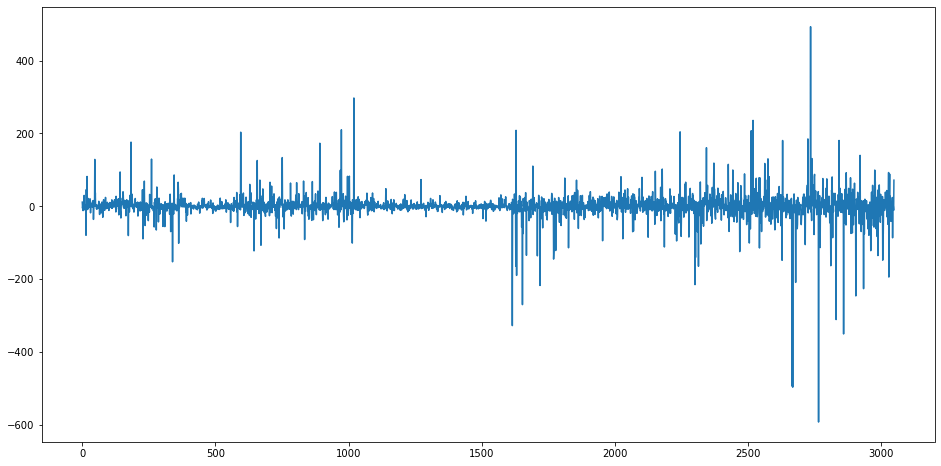

In [88]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(resids)

In [41]:
RMSEs = []
for i in range(216):
    RMSEs.append(mean_squared_error(trues[i], preds[i], squared=False))

In [42]:
np.mean(RMSEs)

1.5019602627473871

In [68]:
CA1_F1_ts

,id,d,sales,wday,month,event_name_1,event_name_2,snap_CA,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_14,lag_21,lag_28
date,,,,,,,,,,,,,,,,,,
2011-01-29,FOODS_1_001_CA_1_validation,d_1,3,1,1,19,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-29,FOODS_1_002_CA_1_validation,d_1,0,1,1,19,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-29,FOODS_1_003_CA_1_validation,d_1,0,1,1,19,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-29,FOODS_1_004_CA_1_validation,d_1,0,1,1,19,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-29,FOODS_1_005_CA_1_validation,d_1,3,1,1,19,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-24,FOODS_1_215_CA_1_validation,d_1913,0,2,4,19,3,0,0.0,0.0,0.0,0.0,4.0,6.0,2.0,0.0,4.0,0.0
2016-04-24,FOODS_1_216_CA_1_validation,d_1913,1,2,4,19,3,0,3.0,1.0,1.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0
2016-04-24,FOODS_1_217_CA_1_validation,d_1913,3,2,4,19,3,0,4.0,1.0,2.0,0.0,2.0,3.0,3.0,5.0,4.0,2.0


In [ ]:
trial.drop(columns=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], inplace=True)

In [ ]:
trial_ts = trial.melt(var_name='d', value_name='sales')

In [ ]:
trial_ts = trial_ts.merge(dates, how='inner', on='d')

In [ ]:
trial_ts.set_index('date', inplace=True)

In [ ]:
trial_ts['lag_1'] = trial_ts['sales'].shift(periods=216*1)

In [ ]:
trial_ts['lag_2'] = trial_ts['sales'].shift(periods=216*2)

In [ ]:
trial_ts['lag_3'] = trial_ts['sales'].shift(periods=216*3)

In [ ]:
trial_ts['lag_4'] = trial_ts['sales'].shift(periods=216*4)

In [ ]:
trial_ts['lag_5'] = trial_ts['sales'].shift(periods=216*5)

In [ ]:
trial_ts['lag_6'] = trial_ts['sales'].shift(periods=216*6)

In [ ]:
trial_ts['lag_7'] = trial_ts['sales'].shift(periods=216*7)

In [ ]:
trial_ts['lag_14'] = trial_ts['sales'].shift(periods=216*14)

In [ ]:
trial_ts['lag_21'] = trial_ts['sales'].shift(periods=216*21)

In [ ]:
trial_ts['lag_28'] = trial_ts['sales'].shift(periods=216*28)

In [ ]:
train = trial_ts['2014-03-28':'2016-03-28']

In [ ]:
test = trial_ts['2016-03-28':]

In [ ]:
X_train = train.drop(['sales', 'd', 'wm_yr_wk', 'event_name_1', 'event_name_2'], axis=1)
X_test = test.drop(['sales', 'd', 'wm_yr_wk', 'event_name_1', 'event_name_2'], axis=1)
y_train = train['sales']
y_test = test['sales']

In [ ]:
y_test

In [ ]:
label = LabelEncoder()
X_train['id'] = label.fit_transform(X_train['id'])
X_test['id'] = label.transform(X_test['id'])

In [ ]:
trial_ts

In [ ]:
X_train

In [ ]:
rf2 = RandomForestRegressor(max_depth=20)
rf2.fit(X_train, y_train)

In [ ]:
rf2.score(X_train, y_train)

In [ ]:
rf2.score(X_test, y_test)

In [ ]:
rf2_preds = rf2.predict(X_test)

In [ ]:
mean_squared_error(y_test, rf2_preds)

In [ ]:
val['dept_id'].unique()

In [ ]:
CA1_f1 = val[(val['store_id'] == 'CA_1')&(val['dept_id'] == 'FOODS_1')]

In [ ]:
CA1_f1_melt = CA1_f1.drop(columns=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])

In [ ]:
CA1_f1_ts = CA1_f1_melt.melt(id_vars=['id'], var_name='d', value_name='sales')

In [ ]:
CA1_f1_ts

In [ ]:
CA1_f1_ts = CA1_f1_ts.merge(dates, how='inner', on='d')

In [ ]:
CA1_f1_ts

In [ ]:
CA1_f1_ts.loc['2011-01-30']

In [ ]:
CA1_f1_ts.set_index('date', inplace=True)

In [ ]:
CA1_f1_ts['lag_1'] = CA1_f1_ts['sales'].shift(periods=216)

In [ ]:
CA1_f1_ts['lag_2'] = CA1_f1_ts['sales'].shift(periods=(216*2))

In [ ]:
CA1_f1_ts['lag_3'] = CA1_f1_ts['sales'].shift(periods=(216*3))

In [ ]:
CA1_f1_ts['lag_4'] = CA1_f1_ts['sales'].shift(periods=(216*4))

In [ ]:
CA1_f1_ts['lag_5'] = CA1_f1_ts['sales'].shift(periods=(216*5))

In [ ]:
CA1_f1_ts['lag_6'] = CA1_f1_ts['sales'].shift(periods=(216*6))

In [ ]:
CA1_f1_ts['lag_7'] = CA1_f1_ts['sales'].shift(periods=(216*7))

In [ ]:
CA1_f1_ts['lag_14'] = CA1_f1_ts['sales'].shift(periods=(216*14))

In [ ]:
CA1_f1_ts['lag_21'] = CA1_f1_ts['sales'].shift(periods=(216*21))

In [ ]:
CA1_f1_ts['lag_28'] = CA1_f1_ts['sales'].shift(periods=(216*28))

In [ ]:
CA1_f1_ts

In [ ]:
train = CA1_f1_ts['2014-03-28':'2016-03-28']

In [ ]:
test = CA1_f1_ts['2016-03-28':]

In [ ]:
# item 7, 100, and 165 are missing, thus 216 per day
test['id'].unique()

In [ ]:
train

In [ ]:
test

In [ ]:
X_train = train.drop(['sales', 'd', 'wm_yr_wk', 'event_name_1', 'event_name_2'], axis=1)
X_test = test.drop(['sales', 'd', 'wm_yr_wk', 'event_name_1', 'event_name_2'], axis=1)
y_train = train['sales']
y_test = test['sales']

In [ ]:
y_test

In [ ]:
label = LabelEncoder()
X_train['id'] = label.fit_transform(X_train['id'])
X_test['id'] = label.transform(X_test['id'])

In [ ]:
rf1 = RandomForestRegressor(max_depth=20)
rf1.fit(X_train, y_train)

In [ ]:
rf1.score(X_train, y_train)

In [ ]:
rf1.score(X_test, y_test)

In [ ]:
rf1_preds = rf1.predict(X_test)

In [ ]:
rf1_preds = pd.Series(rf1_preds).set_axis(y_test.index)

In [ ]:
fig, ax = plt.subplots()
ax.plot(rf1_preds)
ax.plot(y_test)

In [ ]:
mean_squared_error(rf1_preds, y_test, squared=False)

In [ ]:
lgbm_1 = LGBMRegressor()
lgbm_1.fit(X_train, y_train)

In [ ]:
lgbm_1.score(X_train, y_train)

In [ ]:
lgbm_1.score(X_test, y_test)

In [ ]:
xgb_1 = XGBRegressor()
xgb_1.fit(X_train, y_train)

In [ ]:
xgb_1.score(X_train, y_train)

In [ ]:
xgb_1.score(X_test, y_test)

In [ ]:
CA1_join = CA_1[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']]

In [ ]:
#to_melt = train.drop(columns=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])

In [ ]:
#train_ts = to_melt.melt(id_vars=['id'], var_name='d', value_name='sales')

In [ ]:
#to_join = train[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']]

In [ ]:
train_ts = train_ts.merge(to_join, on='id', how='inner')

In [ ]:
train_ts.to_csv('./timeseries.csv')

In [ ]:
train_ts.merge(dates, on='d', how='inner')

In [ ]:
train_ts['value'].max()

In [ ]:
train_ts = pd.melt(train, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='day')

In [ ]:
train_ts

In [ ]:
train = pd.read_csv('C:/Users/TWood/Downloads/m5-forecasting-accuracy/sales_train_evaluation.csv')

In [ ]:
val_ts = pd.melt(val.head(), id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d')

In [ ]:
val_ts = val_ts.merge(dates, on='d')

In [ ]:
val_ts.set_index('date')

In [ ]:
df.describe()

In [ ]:
pd.read_csv('C:/Users/TWood/Downloads/m5-forecasting-accuracy/sample_submission.csv')

In [ ]:
pd.read_csv('C:/Users/TWood/Downloads/m5-forecasting-accuracy/sell_prices.csv')